In [1]:
from collections import deque
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as torch_dist
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from tqdm.notebook import trange
import wandb

import random
# from simpl.collector import ConcurrentCollector, TimeLimitCollector, GPUWorker, Buffer
# from simpl.nn import itemize
# from simpl.math import discount
# from simpl.rl.policy import ContextTruncatedNormalMLPPolicy
# from simpl.rl.qf import MLPQF

C:\Users\Lee Geonju\miniconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ckpt_name = ['spirl_ensemble_prior_1cf63ugt_5000.pt', 'spirl_ensemble_prior_1l9x8mza_5000.pt',
             'spirl_ensemble_prior_1rylba9y_5000.pt', 'spirl_ensemble_prior_3cf7rln5_5000.pt',
             'spirl_ensemble_prior_39ye1gpk_5000.pt']
skill_length = 3
frame_stack = 5
resize_res = 28
is_quantized = True
num_level = 0
# thresholds = list()
thresholds = [10 * i for i in range(0, 20)]
pos = False

In [3]:
import sys
sys.path.append('C:\\Users\\Lee Geonju\\Desktop\\drone\\SiMPL')

In [4]:
import torch.nn as nn
from simpl.nn import MLP

from simpl.nn import ToDeviceMixin
import torch.distributions as torch_dist

from simpl.math import inverse_softplus, inverse_sigmoid

class SkillEncoder(ToDeviceMixin, nn.Module):
    def __init__(self, action_dim, z_dim, hidden_dim, n_lstm, n_mlp_hidden):
        super().__init__()
        
        self.action_dim = action_dim
        
        self.lstm = nn.LSTM(
            action_dim,
            hidden_dim, n_lstm, batch_first=True
        )
        self.mlp = MLP([hidden_dim]*n_mlp_hidden + [2*z_dim], 'relu')
        
        self.register_buffer('prior_loc', torch.zeros(z_dim))
        self.register_buffer('prior_scale', torch.ones(z_dim))
        # self.register_buffer('h0', torch.zeros(n_lstm, hidden_dim))
        # self.register_buffer('c0', torch.zeros(n_lstm, hidden_dim))

    @property
    def prior_dist(self):
        return torch_dist.Independent(torch_dist.Normal(self.prior_loc, self.prior_scale), 1)
    
        
    def dist(self, batch_seq_action):
        
        batch_seq_onehot_action = F.one_hot(batch_seq_action, num_classes=self.action_dim).float()
        batch_seq_out, _ = self.lstm(batch_seq_onehot_action)
        batch_last_out = batch_seq_out[:, -1, :]
        batch_loc, batch_pre_scale = self.mlp(batch_last_out).chunk(2, dim=-1)
        batch_scale = F.softplus(batch_pre_scale)
        
        return torch_dist.Independent(
            torch_dist.Normal(batch_loc, batch_scale)
        , 1)

    
class PriorPolicy(ToDeviceMixin, nn.Module):
    def __init__(self, state_shape, z_dim, hidden_dim, n_hidden,
                 min_scale=0.001, max_scale=None, init_scale=0.1):
        super().__init__()
        
        self.z_dim = z_dim
        if resize_res == 84:
            self.conv_net = nn.Sequential(
                nn.Conv2d(frame_stack, 32, kernel_size=4, stride=3),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=3),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1),
            )
            
        elif resize_res == 28:
            self.conv_net = nn.Sequential(
                nn.Conv2d(frame_stack, 64, kernel_size=4, stride=3),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1),
            )
            
        self.mlp = MLP([128]*n_hidden + [2*z_dim], 'relu')
        
        self.min_scale = min_scale
        self.max_scale = max_scale
        
        if max_scale is None:
            self.pre_init_scale = inverse_softplus(init_scale)
        else:
            self.pre_init_scale = inverse_sigmoid(init_scale / max_scale)
    
    
    def dist(self, batch_state):
        input_dim = batch_state.dim()
        if input_dim > 4:
            batch_shape = batch_state.shape[:-3] 
            data_shape = batch_state.shape[-3:]
            batch_state = batch_state.view(-1, *data_shape)
        batch_h = self.conv_net(batch_state)[..., 0, 0]
        batch_loc, batch_pre_scale = self.mlp(batch_h).chunk(2, dim=-1)

        if self.max_scale is None:
            batch_scale = self.min_scale + F.softplus(self.pre_init_scale + batch_pre_scale)
        else:
            batch_scale = self.min_scale + self.max_scale*torch.sigmoid(self.pre_init_scale + batch_pre_scale)
        
        if input_dim > 4:
            batch_loc = batch_loc.view(*batch_shape, self.z_dim)
            batch_scale = batch_scale.view(*batch_shape, self.z_dim)
        
        return torch_dist.Independent(
            torch_dist.Normal(batch_loc, batch_scale)
        , 1)


class LowPolicy(ToDeviceMixin, nn.Module):
    def __init__(self, action_dim, z_dim, hidden_dim, n_lstm):
        super().__init__()
        
        assert hidden_dim == 128
         
        self.action_dim = action_dim
        self.lstm = nn.LSTM(
            z_dim,
            hidden_dim, n_lstm, batch_first=True, proj_size=action_dim,
        )
        
    def dist(self, batch_z):
        batch_logits, _  = self.lstm(batch_z)     
        return torch_dist.Categorical(logits=batch_logits)

In [7]:
load = [torch.load('../checkpoints/'+path, map_location='cpu') for path in ckpt_name]
prior_policy = [ckpt['prior_policy'] for ckpt in load]
encdec_path = 'spirl_ensemble_encdec_5000.pt'
encdec = torch.load('../checkpoints/'+encdec_path, map_location='cpu')
low_policy = encdec['low_policy']
encoder = encdec['encoder']

low_policy.eval()
encoder.eval()
for policy in prior_policy:
    policy.eval()
    for p in policy.parameters():
        p.requires_grad = False
    
for p in encoder.parameters():
    p.requires_grad = False

for p in low_policy.parameters():
    p.requires_grad = False

In [8]:
# rollout_dir = '../collect/v3'
rollout_dir = '../collect/simple_c_v2'
rollouts = [
    torch.load(f'{rollout_dir}/{filename}')
    for filename in os.listdir(rollout_dir) if filename[-3:] == '.pt'
]
lengths = [
    len(rollout['actions'])
    for rollout in rollouts
]

In [9]:
[filename for filename in os.listdir(rollout_dir) if filename[-3:] == '.pt']
# lengths

['1er8zy6z_rollout0.pt',
 '1ihy1gx5_rollout0.pt',
 '1lu5a46h_rollout0.pt',
 '1owscp12_rollout0.pt',
 '1qomg6um_rollout0.pt',
 '1vwvbbo3_rollout0.pt',
 '2nzrw6tk_rollout0.pt',
 '2vmxjgty_rollout0.pt',
 '3246uo8z_rollout0.pt',
 '3e3c0135_rollout0.pt']

In [10]:
data_states = torch.as_tensor(np.concatenate([
    rollout['states'][1:]
    for rollout in rollouts
]), dtype=torch.float32).squeeze(-1)

data_actions = torch.as_tensor(np.concatenate([
    np.array(rollout['actions'])
    for rollout in rollouts
]), dtype=torch.long)

data_pos = torch.as_tensor(np.concatenate([
    rollout['positions']
    for rollout in rollouts
]), dtype=torch.float32) # squeeze(-1)


data_states.shape, data_actions.shape, data_pos.shape

(torch.Size([1227, 84, 84]), torch.Size([1227]), torch.Size([1227, 3]))

In [11]:
data_available_indices = []
rollout_start_idx = 0
for length in lengths:
    available_indices = torch.arange(frame_stack-1, length-skill_length+1)
    data_available_indices.append(rollout_start_idx + available_indices)
    rollout_start_idx += length
data_available_indices = torch.cat(data_available_indices)

In [9]:
# def add_random_boxes(img, max_k, size=16):
#     h,w = size,size
#     img_size = img.shape[-2]
#     boxes = []
#     n_k = np.random.randint(max_k)
#     for k in range(n_k):
#         y,x = np.random.randint(0,img_size-w,(2,))
        
#         img[:, y:y+h,x:x+w] = 0
#         boxes.append((x,y,h,w))
#     return img

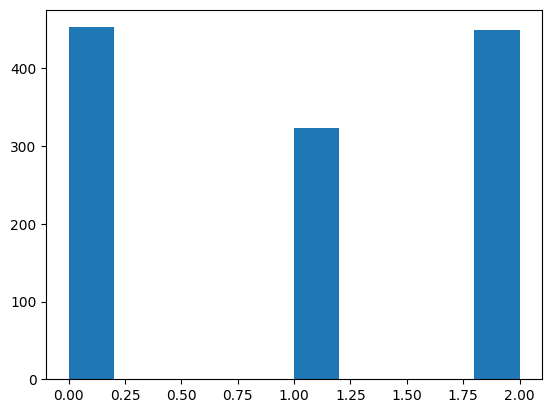

In [11]:
# action prebalance
plt.hist(data_actions.numpy())
plt.show()

idx: 100


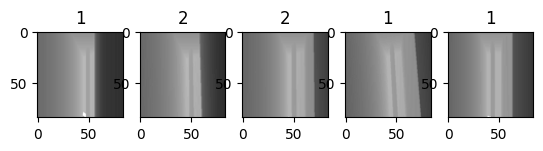

In [11]:
# idx = 0
import random
idx = random.randint(0, data_states.shape[0]-1)
idx = 100
print(f'idx: {idx}')
fig, axes = plt.subplots(1, skill_length)
for t in range(skill_length):
    ax = axes[t]
    ax.imshow(data_states[idx+t].cpu().numpy(), cmap='gray', vmin=123, vmax=256)
    ax.set_title(data_actions[idx+t].item())

In [12]:
data_pos[idx:idx+skill_length]

tensor([[ 206.7691, -303.4766,  -76.0353],
        [ 200.0971, -300.1486,  -77.0769],
        [ 190.1643, -295.1951,  -77.0843],
        [ 186.5282, -294.0250,  -77.5969],
        [ 186.5604, -293.9126,  -77.6036]])

In [13]:
data_pos.shape

torch.Size([1227, 3])

In [14]:
rollouts[0]['positions'][0].shape

(3,)

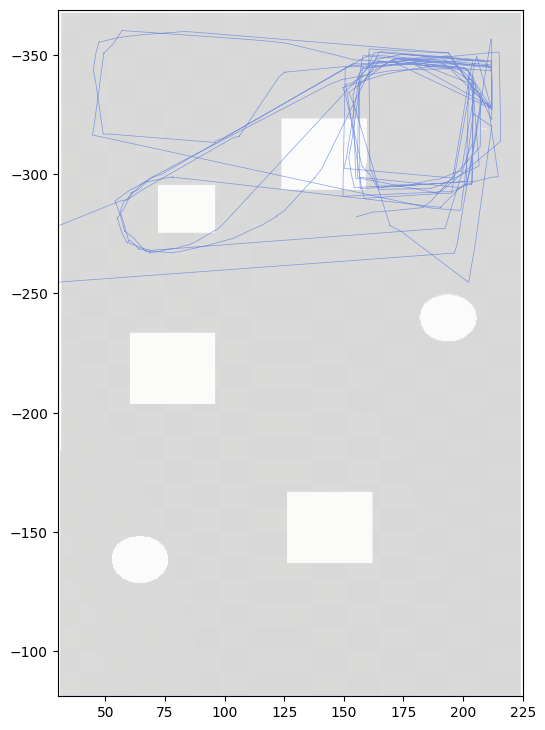

In [12]:
# l, r, d, u = 63, 225, -369, -81
l, r, d, u = 30, 225, -369, -81
plt.figure(figsize=((r - l)//32, abs(d - u)//32))
plt.imshow(
    (1-0.3*(1-plt.imread('map.png'))),
    extent=(l, r, u, d)
)
plt.xlim(l, r);plt.ylim(u, d)

# plt.plot(np.array([150, -225]))
# for i, position in enumerate(dict['positions']):

#     if i>280:
#         plt.plot(*position[:-1], c='royalblue', linewidth=5, alpha=0.6)

# plt.scatter(*np.array([
#     # [position[0], position[1]]
#     # for i, position in enumerate(dict['positions'])
#     # [data_pos.numpy()[idx+t, 0], data_pos.numpy()[idx+t, 1]]
#     # for t in range(skill_length)
#     [data_pos.numpy()[idx, 0], data_pos.numpy()[idx, 1]]
#     for idx in range(data_pos.shape[0])
#     # if i  > 320
# ]).T, c='royalblue', s=5)

plt.plot(*np.array([
    # [position[0], position[1]]
    # for i, position in enumerate(dict['positions'])
    # [data_pos.numpy()[idx+t, 0], data_pos.numpy()[idx+t, 1]]
    # for t in range(skill_length)
    # if i  > 320
    [data_pos.numpy()[t, 0], data_pos.numpy()[t, 1]]
#     for t in range(190, 193)
    for t in range(0, data_pos.shape[0])
    # for t in range(data_states.shape[0])
]).T, c='royalblue', linewidth=.5, alpha=0.6)
plt.show()


# for rollout in rollouts:
#     plt.figure(figsize=((r - l)//32, abs(d - u)//32))
#     plt.imshow(
#         (1-0.3*(1-plt.imread('map.png'))),
#         extent=(l, r, u, d)
#     )
#     plt.xlim(l, r);plt.ylim(u, d)
#     plt.plot(*np.array([
#         [rollout['positions'][t][0], rollout['positions'][t][1]]
#         for t in range(0, len(rollout['positions']))
#     ]).T, c='royalblue', linewidth=.5, alpha=0.6)
    
plt.show()

In [13]:
from torch.utils.data import Dataset, BatchSampler, RandomSampler, DataLoader
from torchvision.transforms import Compose, RandomRotation, CenterCrop, Resize

class TrajDataset(Dataset):
    augment = Compose([
        RandomRotation(5),
        CenterCrop(75),
        Resize(84)
    ])
    
    def __len__(self):
        return len(data_available_indices)
    
    def __getitem__(self, idx_of_available_indices):
        if type(idx_of_availabl|e_indices) != int:
            raise
        idx = data_available_indices[idx_of_available_indices]
        seq_state = data_states[idx-frame_stack+1:idx+skill_length]
        
        stack_seq_state = []
        for stack_i in range(frame_stack):
            stack_seq_state.append(seq_state[stack_i:stack_i+skill_length])
        stack_seq_state = torch.stack(stack_seq_state).transpose(0, 1)
        
        seq_action = data_actions[idx:idx+skill_length]
        
        stack_seq_state = self.augment(add_random_boxes(stack_seq_state, 3))
        
        return stack_seq_state / 255, seq_action
    
class TrajDataset(Dataset):
    augment = Compose([
        RandomRotation(5),
        # CenterCrop(75),
        # Resize(84)
    ])
    
    def __init__(self, indices, validate=False):
        self.indices = indices
        self.validate = validate

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx_of_available_indices):
        if type(idx_of_available_indices) != int:
            raise
        idx = self.indices[idx_of_available_indices]
        seq_state = data_states[idx-frame_stack+1:idx+skill_length]
        
        stack_seq_state = []
        for stack_i in range(frame_stack):
            stack_seq_state.append(seq_state[stack_i:stack_i+skill_length])
        stack_seq_state = torch.stack(stack_seq_state).transpose(0, 1)
        
        seq_action = data_actions[idx:idx+skill_length]
        
        seq_pos = data_pos[idx:idx+skill_length]
        
        if not self.validate: # augmentation
            #stack_seq_state = self.augment(add_random_boxes(stack_seq_state, 3))
            stack_seq_state = self.augment(stack_seq_state)
        
        return stack_seq_state / 255, seq_action, seq_pos


# np_random = np.random.RandomState(seed=2)
# data_available_indices = data_available_indices[np_random.permutation(len(data_available_indices))]
total_len = len(data_available_indices)
training_indices, val_indices = data_available_indices[:int(total_len * 0.9)], data_available_indices[int(total_len * 0.9):]

dataset, val_dataset = TrajDataset(training_indices, True), TrajDataset(val_indices, True)
print(len(dataset), len(val_dataset))

1050 117


In [14]:
loader = DataLoader(
    dataset, 
    batch_size=128,
    drop_last=True,
    shuffle=False,
    # num_workers=4
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=700,
    drop_last=False,
    shuffle=True,
    # num_workers=4
)

In [80]:
data_points = []
for state, action, pos in loader:
    z_dist = encoder.dist(action)
    z_mean = z_dist.mean
    z_prior_dist = [policy.dist(state[:, 0, :, :, :]) for policy in prior_policy]
    mean_z_prior_dist = torch_dist.Independent(torch_dist.Normal(
                            torch.mean(torch.stack([dist.mean for dist in z_prior_dist]), dim=0),
                            torch.sqrt(torch.mean(torch.stack([dist.variance for dist in z_prior_dist]), dim=0)),
                        ), 1)
    
    log_prior_z = mean_z_prior_dist.log_prob(z_mean)
    kl_div = torch_dist.kl.kl_divergence(z_dist, mean_z_prior_dist)
    stddev = torch.linalg.norm(mean_z_prior_dist.stddev, dim=1)
    prior_z = torch.exp(log_prior_z)
    data_points.append((pos, log_prior_z, prior_z, kl_div, stddev))

In [81]:
pos = torch.cat([data_point[0] for data_point in data_points])
prior_z = torch.cat([data_point[2] for data_point in data_points])
log_prior_z = torch.cat([data_point[1] for data_point in data_points])
kl_div = torch.cat([data_point[3] for data_point in data_points])
stddev = torch.cat([data_point[4] for data_point in data_points])

In [82]:
kl_div.shape

torch.Size([1024])

In [51]:
pos[0,:,:2].T

tensor([[ 211.6483,  211.6483,  211.6483],
        [-347.4784, -347.4784, -347.4784]])

In [86]:
pos1 = pos[kl_div>60, :, :]
log_prior_z1 = log_prior_z[kl_div>60]
kl_div1 = kl_div[kl_div>60]
stddev1 = stddev[kl_div>60]

pos2 = pos[kl_div<60, :, :]
log_prior_z2 = log_prior_z[kl_div<60]
kl_div2 = kl_div[kl_div<60]
stddev2 = stddev[kl_div<60]

In [ ]:
kl_div2.min(), kl_div2.max(), kl_div2.mean(), kl_div2.std()

C:\Users\Lee Geonju\AppData\Local\Temp\ipykernel_19384\321833549.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical')


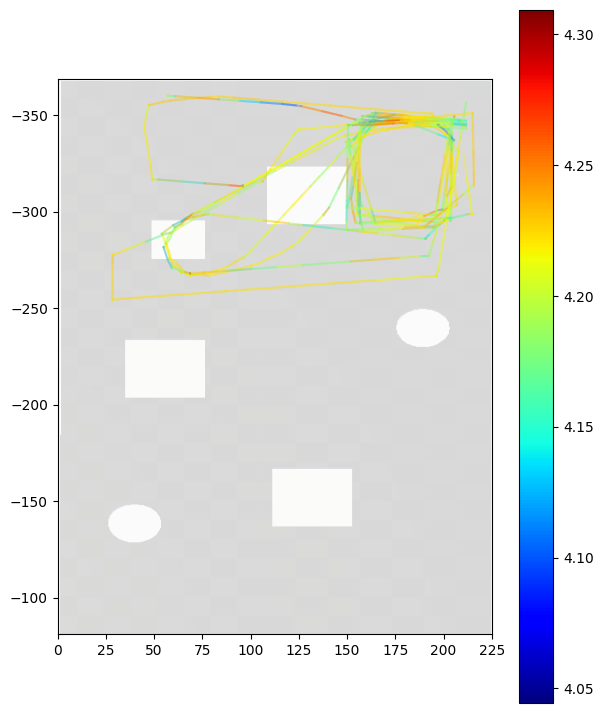

In [93]:
l, r, d, u = 0, 225, -369, -81
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=((r - l)//32, abs(d - u)//32))
plt.imshow(
    (1-0.3*(1-plt.imread('map.png'))),
    extent=(l, r, u, d)
)
plt.xlim(l, r);plt.ylim(u, d)

# plt.plot(*np.array([
#     [data_pos.numpy()[t, 0], data_pos.numpy()[t, 1]]
#     for t in range(0, data_pos.shape[0])
# ]).T, c='royalblue', linewidth=.5, alpha=0.6)


# im = plt.scatter(*np.array([
#     [pos.detach().numpy()[i, 0, 0], pos.detach().numpy()[i, 0, 1]]
#     for i in range(pos.detach().shape[0])
# ]).T, c=log_prior_z, cmap='jet', alpha=0.3)

cmap = cm.jet
# norm = Normalize(vmin=log_prior_z.min(), vmax=log_prior_z.max())
norm = Normalize(vmin=stddev.min(), vmax=stddev.max())

for i in range(pos.detach().shape[0]):
    plt.plot(*pos[i,:,:2].detach().numpy().squeeze().T, c=cmap(norm(stddev[i])), alpha=0.3)
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical')


In [ ]:
l, r, d, u = 0, 225, -369, -81
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1, 2, figsize=((r - l)//16, abs(d - u)//16))
axes[0].imshow(
    (1-0.3*(1-plt.imread('map.png'))),
    extent=(l, r, u, d)
)
axes[0].set_xlim(l, r);axes[0].set_ylim(u, d)

# plt.plot(*np.array([
#     [data_pos.numpy()[t, 0], data_pos.numpy()[t, 1]]
#     for t in range(0, data_pos.shape[0])
# ]).T, c='royalblue', linewidth=.5, alpha=0.6)


#     im = plt.scatter(*np.array([
#         [pos.detach().numpy()[i, 0, 0], pos.detach().numpy()[i, 0, 1]]
#         for i in range(pos.detach().shape[0])
#     ]).T, c=log_prior_z, cmap='jet', alpha=0.3)

cmap = cm.plasma
# norm = Normalize(vmin=log_prior_z.min(), vmax=log_prior_z.max())
norm = Normalize(vmin=stddev1.min(), vmax=stddev1.max())

for i in range(pos1.detach().shape[0]):
    axes[0].plot(*pos1[i,:,:2].detach().numpy().squeeze().T, c=cmap(norm(stddev1[i])), alpha=0.5)
    
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')

axes[1].imshow(
    (1-0.3*(1-plt.imread('map.png'))),
    extent=(l, r, u, d)
)
axes[1].set_xlim(l, r);axes[1].set_ylim(u, d)

# plt.plot(*np.array([
#     [data_pos.numpy()[t, 0], data_pos.numpy()[t, 1]]
#     for t in range(0, data_pos.shape[0])
# ]).T, c='royalblue', linewidth=.5, alpha=0.6)


#     im = plt.scatter(*np.array([
#         [pos.detach().numpy()[i, 0, 0], pos.detach().numpy()[i, 0, 1]]
#         for i in range(pos.detach().shape[0])
#     ]).T, c=log_prior_z, cmap='jet', alpha=0.3)

cmap = cm.plasma
# norm = Normalize(vmin=log_prior_z.min(), vmax=log_prior_z.max())
norm = Normalize(vmin=stddev2.min(), vmax=stddev2.max())

for i in range(pos2.detach().shape[0]):
    axes[1].plot(*pos2[i,:,:2].detach().numpy().squeeze().T, c=cmap(norm(stddev2[i])), alpha=0.5)

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')

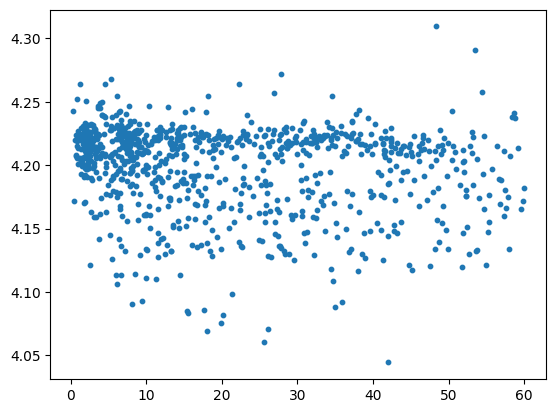

In [87]:
plt.scatter(kl_div2, stddev2, s=10)

In [40]:
[d.stddev.mean() for d in z_prior_dist], mean_z_prior_dist.stddev.mean()

([tensor(0.9171),
  tensor(0.9094),
  tensor(0.9067),
  tensor(0.9164),
  tensor(0.9133)],
 tensor(0.9142))

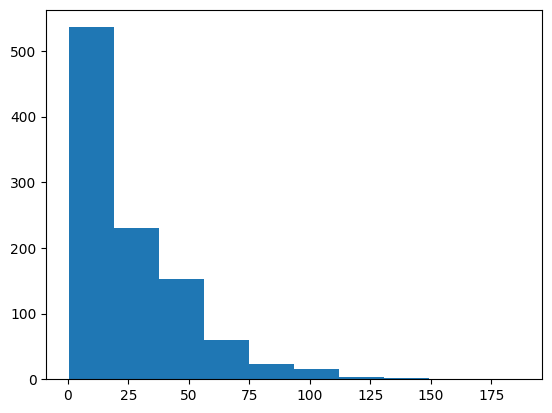

(array([198., 172., 106.,  77.,  48.,  69.,  72.,  48.,  52.,  40.]),
 array([ 0.30242461,  5.26552343, 10.22862244, 15.19172192, 20.1548214 ,
        25.11791992, 30.08101845, 35.04411697, 40.00721741, 44.97031403,
        49.93341446]),
 <BarContainer object of 10 artists>)

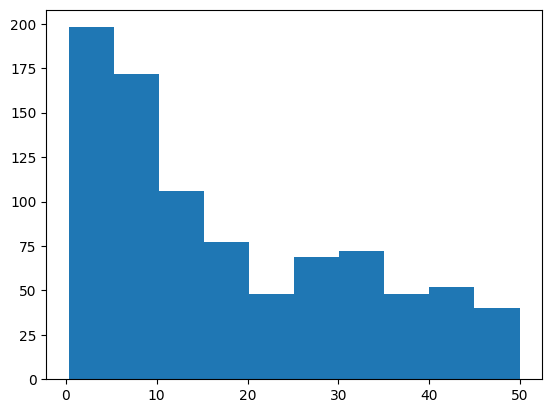

In [36]:
plt.hist(kl_div.numpy())
plt.show()
plt.hist(kl_div[kl_div<50].numpy())

In [2]:
kl_div.min(), kl_div.max(), kl_div.mean(), kl_div.std()

NameError: name 'kl_div' is not defined

In [17]:
import torch.nn as nn
from simpl.nn import MLP

from simpl.nn import ToDeviceMixin
import torch.distributions as torch_dist

from simpl.math import inverse_softplus, inverse_sigmoid


class SkillEncoder(ToDeviceMixin, nn.Module):
    def __init__(self, action_dim, z_dim, hidden_dim, n_lstm, n_mlp_hidden):
        super().__init__()
        
        self.action_dim = action_dim
        
        self.lstm = nn.LSTM(
            action_dim,
            hidden_dim, n_lstm, batch_first=True
        )
        self.mlp = MLP([hidden_dim]*n_mlp_hidden + [2*z_dim], 'relu')
        
        self.register_buffer('prior_loc', torch.zeros(z_dim))
        self.register_buffer('prior_scale', torch.ones(z_dim))
        # self.register_buffer('h0', torch.zeros(n_lstm, hidden_dim))
        # self.register_buffer('c0', torch.zeros(n_lstm, hidden_dim))

    @property
    def prior_dist(self):
        return torch_dist.Independent(torch_dist.Normal(self.prior_loc, self.prior_scale), 1)
    
        
    def dist(self, batch_seq_action):
        # batch_h0 = self.h0[:, None, :].expand(-1, len(batch_seq_state), -1)
        # batch_c0 = self.c0[:, None, :].expand(-1, len(batch_seq_state), -1)
        
        batch_seq_onehot_action = F.one_hot(batch_seq_action, num_classes=self.action_dim).float()
        batch_seq_out, _ = self.lstm(batch_seq_onehot_action)
        batch_last_out = batch_seq_out[:, -1, :]
        batch_loc, batch_pre_scale = self.mlp(batch_last_out).chunk(2, dim=-1)
        batch_scale = F.softplus(batch_pre_scale)
        
        return torch_dist.Independent(
            torch_dist.Normal(batch_loc, batch_scale)
        , 1)

class PriorPolicy(ToDeviceMixin, nn.Module):
    def __init__(self, state_shape, z_dim, hidden_dim, n_hidden,
                 min_scale=0.001, max_scale=None, init_scale=0.1):
        super().__init__()
        
        assert state_shape == (5, 84, 84)
        assert hidden_dim == 128
        
        self.z_dim = z_dim
        self.conv_net = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=4, stride=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=3),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1),
        )
        self.mlp = MLP([128]*n_hidden + [2*z_dim], 'relu')
        
        self.min_scale = min_scale
        self.max_scale = max_scale
        
        if max_scale is None:
            self.pre_init_scale = inverse_softplus(init_scale)
        else:
            self.pre_init_scale = inverse_sigmoid(init_scale / max_scale)
        
    def dist(self, batch_state):
        input_dim = batch_state.dim()
        if input_dim > 4:
            batch_shape = batch_state.shape[:-3] 
            data_shape = batch_state.shape[-3:]
            batch_state = batch_state.view(-1, *data_shape)
        
        batch_h = self.conv_net(batch_state)[..., 0, 0]
        batch_loc, batch_pre_scale = self.mlp(batch_h).chunk(2, dim=-1)

        if self.max_scale is None:
            batch_scale = self.min_scale + F.softplus(self.pre_init_scale + batch_pre_scale)
        else:
            batch_scale = self.min_scale + self.max_scale*torch.sigmoid(self.pre_init_scale + batch_pre_scale)
        
        if input_dim > 4:
            batch_loc = batch_loc.view(*batch_shape, self.z_dim)
            batch_scale = batch_scale.view(*batch_shape, self.z_dim)
        
        return torch_dist.Independent(
            torch_dist.Normal(batch_loc, batch_scale)
        , 1)

class LowPolicy(ToDeviceMixin, nn.Module):
    def __init__(self, action_dim, z_dim, hidden_dim, n_lstm):
        super().__init__()
        
        assert hidden_dim == 128
        
        self.action_dim = action_dim
        self.lstm = nn.LSTM(
            z_dim,
            hidden_dim, n_lstm, batch_first=True, proj_size=action_dim,
        )
        
    def dist(self, batch_z):
        batch_logits, _  = self.lstm(batch_z)     
        return torch_dist.Categorical(logits=batch_logits)

In [17]:
config = dict(
    encoder=dict(hidden_dim=256, n_lstm=2, n_mlp_hidden=2),
    prior_policy=dict(hidden_dim=128, n_hidden=2, init_scale=1, max_scale=2),
    low_policy=dict(hidden_dim=128, n_hidden=2),
    # reuse_rate=128,
    batch_size=128,
    z_dim=10,
    reg_scale=0.001,
)
gpu = 0
state_shape = (5, 84, 84)
action_dim = 3
z_dim = config['z_dim']

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
def compute(batch_seq_state, batch_seq_action):
    batch_seq_state = batch_seq_state#.to(gpu)
    batch_seq_action = batch_seq_action#.to(gpu)

    batch_skill_dist = encoder.dist(batch_seq_action)
    batch_skill_prior_dist = prior_policy.dist(batch_seq_state[:, 0, :])

    batch_skill = batch_skill_dist.rsample()
    batch_seq_skill = batch_skill[:, None, :].expand(-1, skill_length, -1)

    # batch_seq_policy_dist = low_policy.dist(batch_seq_state, batch_seq_skill)
    batch_seq_policy_dist = low_policy.dist(batch_seq_skill)
    
    return batch_skill_dist, batch_skill_prior_dist, batch_seq_policy_dist

In [ ]:
from sklearn.manifold import TSNE

class Flatter:
    def __init__(self, d):
        self.shapes = {}
        arrs = []
        for k, v in d.items():
            self.shapes[k] = v.shape[:-1]
            arrs.append(v.reshape(-1, v.shape[-1]))
        self.flattened = np.concatenate(arrs, axis=0)
    
    def unflatten(self, arr):
        accum = 0
        d = {}
        for k, shape in self.shapes.items():
            l = np.prod(shape)
            v = arr[accum:accum+l]
            d[k] = v.reshape(*shape, -1)
            accum += l
        return d


In [ ]:
def draw_skill_space(ax, seq_actions, skills, query_action_idx=None, query_skills=None):
    seq_converted_actions = seq_actions.clone()
    seq_converted_actions[seq_converted_actions==0] = -1
    seq_converted_actions[seq_converted_actions==1] = 1
    seq_converted_actions[seq_converted_actions==2] = 0
    
    data = {
        'skills': skills.detach().cpu().numpy(),
    }
    if query_skills is not None:
        data['query_skills'] = query_skills.detach().cpu().numpy()

    flatter = Flatter(data)
    flattened_2d = TSNE().fit_transform(flatter.flattened)
    data_2d = flatter.unflatten(flattened_2d)
    
    skills_2d  = data_2d['skills']
    if query_skills is not None:
        query_skills_2d  = data_2d['query_skills']
    
    ax.scatter(*skills_2d.T, c=seq_converted_actions.sum(-1), cmap='seismic', edgecolor='black', linewidth=0.1)
    if query_skills is not None:
        ax.scatter(*skills_2d[query_action_idx].T, marker='^', edgecolor='black', linewidth=1)
        ax.scatter(*query_skills_2d.T, marker='x')

In [ ]:
import random
idx1 = 0
# idx1 = random.randint(0, len(loader)-1)
idx2 = random.randint(0, 699)
# idx1, idx2 = 0, 30
batch_seq_state, batch_seq_action = list(loader)[idx1]
# batch_seq_state, batch_seq_action = batch_seq_state.to(gpu), batch_seq_action.to(gpu)
skill_enc_dist, skill_prior_dist, seq_policy_dist = compute(batch_seq_state, batch_seq_action)

print(idx1, idx2)

In [ ]:
# for k, v in dict(low_policy.named_parameters()).items():
#     print(k, v.shape)

In [ ]:
from matplotlib import colors
norm = colors.Normalize(vmin=0, vmax=1)

In [ ]:
# fig, axes = plt.subplots(1, skill_length, dpi=200)
# for t in range(skill_length):
#     ax = axes[t]
#     ax.imshow(batch_seq_state[idx, 0, t].cpu().numpy(), cmap='gray')

fig, axes = plt.subplots(1, skill_length, dpi=200)
for t in range(skill_length):
    ax = axes[t]
    ax.imshow(batch_seq_state[idx2, -1, t].cpu().numpy(), cmap='gray')
    ax.set_title(batch_seq_action[idx2, t].item())

In [ ]:
plt.figure(dpi=200)
draw_skill_space(
    plt.gca(), batch_seq_action, skill_enc_dist.mean,
    idx2, skill_prior_dist.sample((10, ))[:, idx2, :]
)

In [ ]:
low_policy.dist(
    skill_prior_dist.sample()[idx][None, None, :].expand(-1, skill_length, -1)
).logits[0].argmax(-1)

In [ ]:
batch_seq_state, batch_seq_action = next(iter(val_loader))
skill_enc_dist, skill_prior_dist, seq_policy_dist = compute(batch_seq_state, batch_seq_action)

In [ ]:
batch_seq_action[20:30]

In [ ]:
idx = 21
fig, axes = plt.subplots(1, skill_length, dpi=200)
for t in range(skill_length):
    ax = axes[t]
    ax.imshow(batch_seq_state[idx, 0, t].cpu().numpy())

fig, axes = plt.subplots(1, skill_length, dpi=200)
for t in range(skill_length):
    ax = axes[t]
    ax.imshow(batch_seq_state[idx, -1, t].cpu().numpy())
    ax.set_title(batch_seq_action[idx, t].item())

In [ ]:
plt.figure(dpi=200)
draw_skill_space(
    plt.gca(), batch_seq_action, skill_enc_dist.mean,
    idx, skill_prior_dist.sample((20, ))[:, idx, :]
)

In [ ]:
low_policy.dist(
    skill_prior_dist.sample()[idx][None, None, :].expand(-1, skill_length, -1)
).logits[0].argmax(-1)

In [ ]:
np.sum([
    0 in seq_action and 1 in seq_action
    for seq_action in seq_policy_dist.logits.argmax(-1).tolist()
])